# Proyecto Final del curso de Reconocimiento de Patrones
### Maestría en Electrónica del TEC
### Autor: Pamela Salazar Espinoza

Este cuaderno corresponde al proyecto del curso de reconocimiento de patrones del TEC. El reconocimiento de voz o reconocimiento del habla es una rama de la inteligencia artificial cuya finalidad es posibilitar la comunicación entre humanos y sistemas informáticos. Un sistema de reconocimiento de voz tiene la capacidad de detectar y entender las palabras que un ser humano emite de forma natural. En un esfuerzo por entrenar estos sistemas se han creado diferentes bases de datos en distintos idiomas, con diferentes de acentos por ejemplo la enconteada en: 

https://commonvoice.mozilla.org/es/datasets

El objetivo de este proyecto es entrenar una red neuronal de reconocimiento de voz que clasifique la comida que el usuario desea del menu de una soda. Las clases son:

| Clase | Clase ID |
|----------|----------|
| Pinto     | 0   | 
| Casado    | 1  | 
| Empanada  de Carne | 3 |
| Empanada  de Pollo | 4  |
| Empanada  de Frijol | 5  |
| Arroz con pollo | 6  |
| Chifrijo | 7 |

En el proceso de reconocimiento de voz afectan difirentes caracterisitcas como el idioma, acento y tono de voz. Para recolectar los datos  de entremiento y prueba se grabo con un celular. Los audios fueron grabados por 3 personas de difrente edad, lugar de procedencia y genero:

| Ganero | Edad |  Provincia | Muestras por lase |
|----------|----------|----------|----------|
| Masculino    | 37   | San Jose   | 300 |
| Femenino   | 59  | Guanacaste  | 300 |
| Fmenino   | 30 |  Alajuela | 300 |






In [1]:
##Importar librerias necesarias

import os
import pandas as pd
import numpy as np
import random
import pickle
import seaborn as sns
import librosa
import pickle
import matplotlib.pyplot as plt
import librosa.display
from sklearn import metrics as metrics_skl
from tensorflow.keras import datasets, layers, models
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras import utils as np_utils
from keras.losses import CategoricalCrossentropy
from tensorflow.keras  import metrics 
from sklearn import model_selection

C:\Users\psalazar\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### 1. Limpieza de datos

1. Crear una tabla de los archivos con sus respectivas carpetas

In [2]:
contenido = os.listdir('.\dataset')
archvos_list = []
carpeta_list = []
carpeta_list1 = []
for carpeta in contenido:
    archivos = os.listdir('.\dataset\\' + carpeta)
    carpeta_list1.append(carpeta)
    for archivo in archivos:
        archvos_list.append(archivo)
        carpeta_list.append(carpeta)

df = pd.DataFrame()
df['Carpeta']  = carpeta_list
df['Archivos'] = archvos_list 
df

,Carpeta,Archivos
0,ArrozPollo,20240413-202337.wav
1,ArrozPollo,20240413-202545.wav
2,ArrozPollo,20240413-202551.wav
3,ArrozPollo,20240413-202557.wav
4,ArrozPollo,20240413-202604.wav
...,...,...
6298,Pinto,Zule_pinto296.wav
6299,Pinto,Zule_pinto297.wav
6300,Pinto,Zule_pinto298.wav
6301,Pinto,Zule_pinto299.wav


2. Clasificar las muestras.

In [3]:
clases_list = []
clasesID_list = []
for carpeta in df['Carpeta']:
    if carpeta == 'Pinto':
        clase = 'Pinto'
        id = 0
    elif carpeta == 'Casado':
        clase = 'Casado'
        id = 1
    elif carpeta == 'EmpanadaCarne':
        clase = 'Empanada de Carne'
        id = 2
    elif carpeta == 'EmpanadaPollo':
        clase = 'Empanada de Pollo'
        id = 3
    elif carpeta == 'EmpanadaFrijol':
        clase = 'Empanada de Frijol'
        id = 4
    elif carpeta == 'ArrozPollo':
        clase = 'Arroz con pollo'
        id = 5
    else: 
        clase = 'Chifrijo'
        id = 6
    clases_list.append(clase)
    clasesID_list.append(id)
df['Clase'] = clases_list
df['Clase ID'] = clasesID_list

df.drop(df[(df['Clase'] == 'desconocido')].index, inplace=True)
df

,Carpeta,Archivos,Clase,Clase ID
0,ArrozPollo,20240413-202337.wav,Arroz con pollo,5
1,ArrozPollo,20240413-202545.wav,Arroz con pollo,5
2,ArrozPollo,20240413-202551.wav,Arroz con pollo,5
3,ArrozPollo,20240413-202557.wav,Arroz con pollo,5
4,ArrozPollo,20240413-202604.wav,Arroz con pollo,5
...,...,...,...,...
6298,Pinto,Zule_pinto296.wav,Pinto,0
6299,Pinto,Zule_pinto297.wav,Pinto,0
6300,Pinto,Zule_pinto298.wav,Pinto,0
6301,Pinto,Zule_pinto299.wav,Pinto,0


3. Dividir datos de entrenamineto y validacion.

In [4]:
from sklearn.model_selection import train_test_split

Usar el 20% de os datos de clase "pinto" para validacion

In [5]:
df1 = df[df['Clase']=='Pinto'].reset_index()
df1 = df1.drop(['index'],axis=1)
train_pinto, test_pinto = train_test_split(df1, test_size = 0.20, shuffle = False)

Usar el 20% de os datos de clase "casado" para validacion

In [6]:
df1 = df[df['Clase']=='Casado'].reset_index()
df1 = df1.drop(['index'],axis=1)
train_casado, test_casado = train_test_split(df1, test_size = 0.20, shuffle = False)

Usar el 20% de los datos de clase "empanada de carne" para validacion

In [7]:
df1 = df[df['Clase']=='Empanada de Carne'].reset_index()
df1 = df1.drop(['index'],axis=1)
train_carne, test_carne = train_test_split(df1, test_size = 0.20, shuffle = False)

Usar el 20% de los datos de clase "empanada de pollo" para validacion

In [8]:
df1 = df[df['Clase']=='Empanada de Pollo'].reset_index()
df1 = df1.drop(['index'],axis=1)
train_pollo, test_pollo = train_test_split(df1, test_size = 0.20, shuffle = False)

Usar el 20% de los datos de clase "empanada de frijol" para validacion

In [9]:
df1 = df[df['Clase']=='Empanada de Frijol'].reset_index()
df1 = df1.drop(['index'],axis=1)
train_frijol, test_frijol = train_test_split(df1, test_size = 0.20, shuffle = False)

Usar el 20% de los datos de clase "arroz con pollo" para validacion

In [10]:
df1 = df[df['Clase']=='Arroz con pollo'].reset_index()
df1 = df1.drop(['index'],axis=1)
train_apollo, test_apollo = train_test_split(df1, test_size = 0.20, shuffle = False)

Usar el 20% de los datos de clase "chifrijo" para validacion

In [11]:
df1 = df[df['Clase']=='Chifrijo'].reset_index()
df1 = df1.drop(['index'],axis=1)
train_chifrijo, test_chifrijo = train_test_split(df1, test_size = 0.20, shuffle = False)

Crear dataset de entrenamiento

In [12]:
train = pd.concat([train_pinto,train_casado, train_carne, train_pollo,train_frijol,
                   train_apollo,train_chifrijo], axis=0)
train['Group'] = 'Train'

Crear dataset de prueba

In [13]:
test = pd.concat([test_pinto,test_casado, test_carne, test_pollo,test_frijol,
                   test_apollo,test_chifrijo], axis=0)
test['Group'] = 'Test'

Visualizar datos entrenamiento y datos de prueba

In [14]:
df = pd.concat([train,test], axis=0).reset_index()
df = df.drop(['index'],axis=1)
df

,Carpeta,Archivos,Clase,Clase ID,Group
0,Pinto,20240412_210743.wav,Pinto,0,Train
1,Pinto,20240412_210750.wav,Pinto,0,Train
2,Pinto,20240412_210755.wav,Pinto,0,Train
3,Pinto,20240412_210800.wav,Pinto,0,Train
4,Pinto,20240412_210804.wav,Pinto,0,Train
...,...,...,...,...,...
6298,Chifrijo,Pame_chifrijo_1496.wav,Chifrijo,6,Test
6299,Chifrijo,Pame_chifrijo_1497.wav,Chifrijo,6,Test
6300,Chifrijo,Pame_chifrijo_1498.wav,Chifrijo,6,Test
6301,Chifrijo,Pame_chifrijo_1499.wav,Chifrijo,6,Test


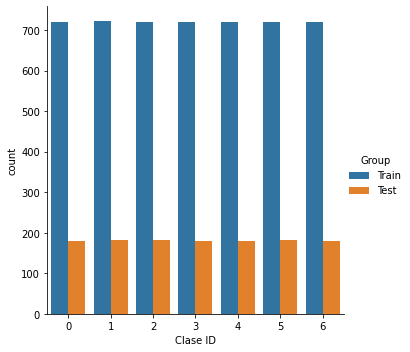

In [15]:
sns.catplot(data=df,kind='count',x='Clase ID',hue='Group')

3. Crear espectogramas
Nota, para crear los espectogramas hay que cambiar el formato del archivo a mp3.

In [16]:
def spectogram (audio_file):
    fs = 16000
    y, sr = librosa.load(audio_file, sr = 16000)
    if len(y) < fs:
       y = np.concatenate((y,np.zeros((fs-len(y)),dtype='int')))
    elif len(y) > fs:
        y = y[:fs]
    S = librosa.feature.melspectrogram(y=y, sr=fs, n_mels=40,n_fft =  25*fs//1000, win_length = 25*fs//1000, hop_length = 10*fs//1000, center=True,
        power=2)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

En la siguiente celda se guarda el espectograma de cada archivo de audio en un archivo dentro de la carpeta 'espectogramas'. 

In [17]:
#for i in range(len(df['Archivos'])):
#    file = df['Archivos'][i]
#    carpeta = df['Carpeta'][i]
#    path_audio = 'dataset\\' + carpeta +  '\\' + file
#    name, extension = file.split('.')
#    file_name = carpeta +  '_' +  name + '.pickle'
#    S_dB = spectogram (path_audio)   
#    path = 'espectogramas/'+ file_name
#    with open(path, "wb") as f:
#        pickle.dump(S_dB, f)

In [18]:
espectograma = []
for i in range(len(df['Archivos'])):
    file = df['Archivos'][i]
    carpeta = df['Carpeta'][i]
    name, extension = file.split('.')
    file_name = carpeta +  '_' +  name + '.pickle'
    espectograma.append(file_name)
df['Path de espectograma'] = espectograma
df

,Carpeta,Archivos,Clase,Clase ID,Group,Path de espectograma
0,Pinto,20240412_210743.wav,Pinto,0,Train,Pinto_20240412_210743.pickle
1,Pinto,20240412_210750.wav,Pinto,0,Train,Pinto_20240412_210750.pickle
2,Pinto,20240412_210755.wav,Pinto,0,Train,Pinto_20240412_210755.pickle
3,Pinto,20240412_210800.wav,Pinto,0,Train,Pinto_20240412_210800.pickle
4,Pinto,20240412_210804.wav,Pinto,0,Train,Pinto_20240412_210804.pickle
...,...,...,...,...,...,...
6298,Chifrijo,Pame_chifrijo_1496.wav,Chifrijo,6,Test,Chifrijo_Pame_chifrijo_1496.pickle
6299,Chifrijo,Pame_chifrijo_1497.wav,Chifrijo,6,Test,Chifrijo_Pame_chifrijo_1497.pickle
6300,Chifrijo,Pame_chifrijo_1498.wav,Chifrijo,6,Test,Chifrijo_Pame_chifrijo_1498.pickle
6301,Chifrijo,Pame_chifrijo_1499.wav,Chifrijo,6,Test,Chifrijo_Pame_chifrijo_1499.pickle


4. Entrenar la red neuronal.

Preparar datos para la red neuronal

In [19]:
def writeSpectogram (specfile):
    with open(specfile, "rb") as f:
        S_dB = pickle.load(f)
    S_dB=S_dB.astype(np.float32)
    return S_dB

In [20]:
D_train=[]
D_test=[]
for i in range(len(df['Clase'])):
    classID = df['Clase ID'][i] 
    path_spect = 'espectogramas' + '/' + df['Path de espectograma'][i]
    spec = writeSpectogram(path_spect)
    spec =spec .astype(np.float32)
    if df['Group'][i] == 'Train':
        D_train.append((spec,classID))
    else:
        D_test.append((spec,classID))


In [21]:
dataset_train=D_train
dataset_test=D_test
random.shuffle(dataset_train)
random.shuffle(dataset_test)
train=dataset_train
test=dataset_test
X_train, y_train = zip(*train)
X_test, y_test = zip(*test)
X_train = np.array([x.reshape( (40, 101, 1) ) for x in X_train])
X_test = np.array([x.reshape( (40, 101, 1) ) for x in X_test])
# Normalización
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
mean = np.mean(X_test, axis=0)
std = np.std(X_test, axis=0)
X_test = (X_test - mean)/std
y_train = np.array(np_utils.to_categorical(y_train, 12))
y_test = np.array(np_utils.to_categorical(y_test, 12))

Crear red

In [22]:
# Construct model 
model = models.Sequential()

# model
model.add(layers.Conv2D( input_shape=(40, 101, 1),filters=12, kernel_size=(3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation(activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(layers.Conv2D(filters=24, kernel_size=(3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation(activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
model.add(layers.Conv2D(filters=48, kernel_size=(3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation(activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3),strides=(2, 2), padding='same'))
model.add(layers.Conv2D(filters=48, kernel_size=(3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation(activation='relu'))
model.add(layers.Conv2D(filters=48, kernel_size=(3, 3), padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation(activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(1, 13), strides=(1, 1), padding='same'))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(12, activation='softmax'))


model.summary()

c:\Users\psalazar\.pyenv\pyenv-win\versions\3.9.6\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 101, 12)    │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 101, 12)    │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 40, 101, 12)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 51, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 51, 24)     │         2,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 51, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 20, 51, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 26, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 26, 48)     │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 26, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10, 26, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 13, 48)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 13, 48)      │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 13, 48)      │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 5, 13, 48)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 13, 48)      │        20,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 13, 48)      │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 5, 13, 48)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 13, 48)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 13, 48)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │        37,452 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 92,892 (362.86 KB)

 Trainable params: 92,532 (361.45 KB)

 Non-trainable params: 360 (1.41 KB)

Compilar el modelo

In [23]:
model.compile(optimizer=Adam(learning_rate=3e-6),
              loss=CategoricalCrossentropy(),
              metrics=[metrics.CategoricalAccuracy()])

Entrenar modelo

In [24]:
model.fit(X_train, y_train, epochs=400,batch_size=100, validation_data= (X_test, y_test))

Epoch 1/400
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - categorical_accuracy: 0.0542 - loss: 3.9623 - val_categorical_accuracy: 0.0744 - val_loss: 2.4182
Epoch 2/400
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - categorical_accuracy: 0.1014 - loss: 3.3607 - val_categorical_accuracy: 0.1726 - val_loss: 2.3493
Epoch 3/400
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - categorical_accuracy: 0.1322 - loss: 2.9452 - val_categorical_accuracy: 0.2074 - val_loss: 2.2798
Epoch 4/400
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - categorical_accuracy: 0.1691 - loss: 2.6764 - val_categorical_accuracy: 0.1956 - val_loss: 2.1992
Epoch 5/400
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - categorical_accuracy: 0.1739 - loss: 2.5447 - val_categorical_accuracy: 0.2019 - val_loss: 2.1161
Epoch 6/400
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - categorical_accuracy: 0.2094 - loss: 2.3987 - val_categorical_accuracy: 0.2249 - val_loss: 2.0215
Epoch 7/400
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - categorical_accuracy: 0.22

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


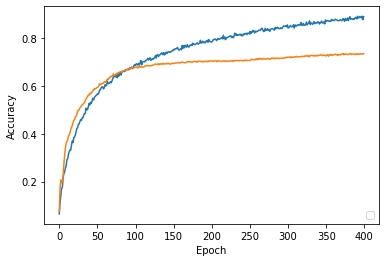

In [25]:
plt.plot(model.history.history['categorical_accuracy'])
plt.plot(model.history.history['val_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


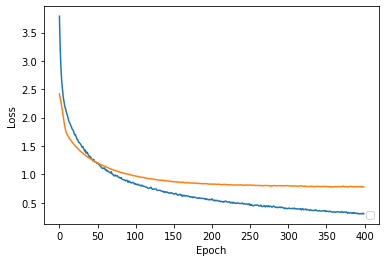

In [26]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

5. Evaluar modelo

In [27]:
predictions = model.predict(X_test,batch_size=128)
decoded_y_test = y_test.argmax(axis=1)
decoded_predictions = predictions.argmax(axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


In [28]:
print(metrics_skl.classification_report(decoded_y_test,decoded_predictions))

              precision    recall  f1-score   support

           0       0.77      0.96      0.86       180
           1       0.92      0.87      0.89       181
           2       0.65      0.29      0.40       181
           3       0.33      0.43      0.38       180
           4       0.69      0.77      0.73       180
           5       0.93      0.87      0.90       181
           6       0.94      0.96      0.95       180

    accuracy                           0.74      1263
   macro avg       0.75      0.74      0.73      1263
weighted avg       0.75      0.74      0.73      1263



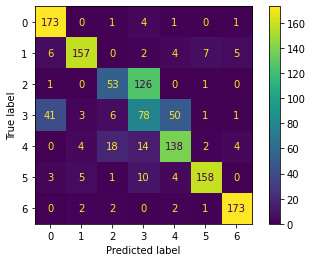

In [29]:
matrix = metrics_skl.confusion_matrix(decoded_y_test,decoded_predictions)
cm_dispaly = metrics_skl.ConfusionMatrixDisplay(matrix)
cm_dispaly.plot()
plt.show()